### **Step-1 Import Required Packages**

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import warnings
from IPython.display import display
from pickle import dump

In [108]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',50)
pd.set_option('display.float_format','{:.2f}'.format)

### **Step-2 Load the Dataset**

In [109]:
# File is placed in the same path
org_df = pd.read_csv('Advertising.csv')

# Lets create a copy of this df, & perform all operations on it
adv_df = org_df.copy()

### **Step-3 Data Understanding**

In [110]:
adv_df.head()

,TV,radio,newspaper,sales
0,230100,37800,69200,22100
1,44500,39300,45100,10400
2,17200,45900,69300,9300
3,151500,41300,58500,18500
4,180800,10800,58400,12900


In [111]:
adv_df.shape

(200, 4)

In [112]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   TV         200 non-null    int64
 1   radio      200 non-null    int64
 2   newspaper  200 non-null    int64
 3   sales      200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [113]:
categorical_col = [key for key, value in adv_df.dtypes.items() if value == 'object']
check = [key for key, value in adv_df.dtypes.items() if value == 'int64']
continous_col = [key for key, value in adv_df.dtypes.items() if value == 'float64']

In [114]:
categorical_col

[]

In [115]:
continous_col

[]

In [116]:
check

['TV', 'radio', 'newspaper', 'sales']

In [117]:
adv_df.describe()

,TV,radio,newspaper,sales
count,200.00,200.00,200.00,200.00
mean,147042.50,23264.00,30554.00,14022.50
std,85854.24,14846.81,21778.62,5217.46
min,700.00,0.00,300.00,1600.00
25%,74375.00,9975.00,12750.00,10375.00
50%,149750.00,22900.00,25750.00,12900.00
75%,218825.00,36525.00,45100.00,17400.00
max,296400.00,49600.00,114000.00,27000.00


**Here all input variables & output variable are continous variables**

In [118]:
continous_col = check[:3]   # excluding output variable

In [119]:
del categorical_col, check

In [120]:
adv_df.corr()

,TV,radio,newspaper,sales
TV,1.00,0.05,0.06,0.78
radio,0.05,1.00,0.35,0.58
newspaper,0.06,0.35,1.00,0.23
sales,0.78,0.58,0.23,1.00


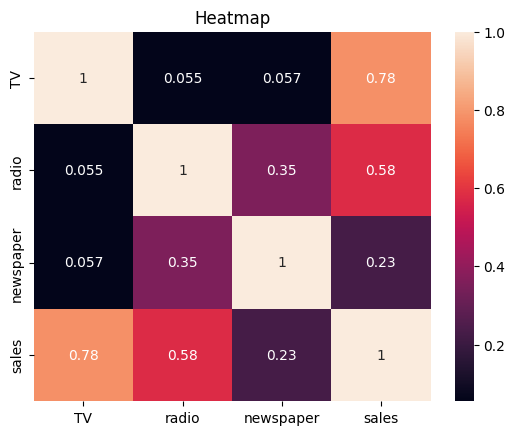

In [121]:
sns.heatmap(adv_df.corr(),annot=True)
plt.title('Heatmap')
plt.show()

In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['features'] = continous_col
vif_data['VIF value'] = [variance_inflation_factor(adv_df[continous_col].values, i) for i in range(adv_df[continous_col].shape[1])]

vif_data

,features,VIF value
0,TV,2.49
1,radio,3.29
2,newspaper,3.06


**Insights**
- We observe that all input columns are independent of each other.
- Every corrrelation value < 0.5
- Each VIF < 5, Moderate multicollinearity, generally acceptable.

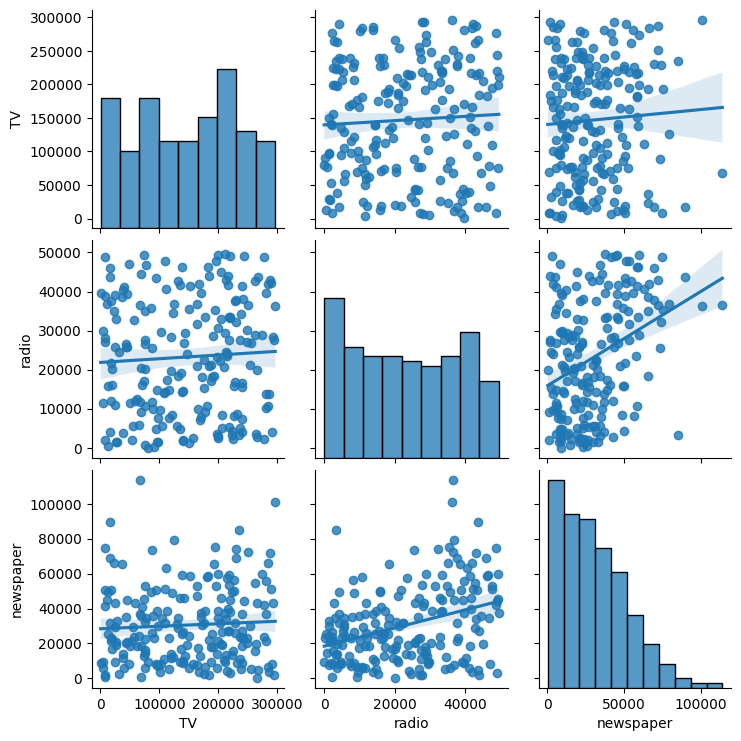

In [123]:
sns.pairplot(adv_df[continous_col],kind='reg')
plt.show()

**Check relationship of each input predictor with target variable**

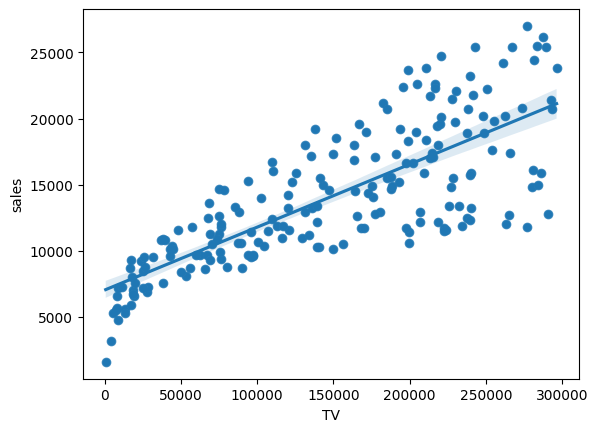

In [124]:
sns.scatterplot(x = adv_df['TV'],y=adv_df['sales'])
sns.regplot(x = adv_df['TV'],y=adv_df['sales'])
plt.show()

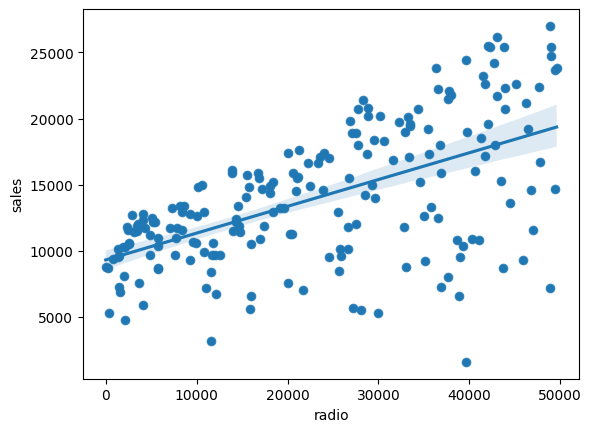

In [125]:
sns.scatterplot(x = adv_df['radio'],y=adv_df['sales'])
sns.regplot(x = adv_df['radio'],y=adv_df['sales'])
plt.show()

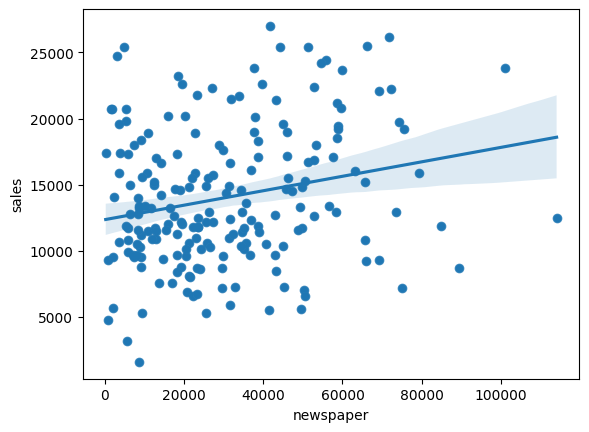

In [126]:
sns.scatterplot(x = adv_df['newspaper'],y=adv_df['sales'])
sns.regplot(x = adv_df['newspaper'],y=adv_df['sales'])
plt.show()

**Insights**
- From correlation matrix, we can say that newspaper is very less linearly related to output column: 'sales'.
- So, we can remove it, but we will further confirm this when we will calculate its p_value while doing modelling.

### **Step-4 Data Preprocessing**

- Data Cleansing
- Data Wrangling
- Outliers removal (if required)
- Features Engineering
- Features selection

In [127]:
adv_df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

**Insights**
- There are no missing values

In [128]:
adv_df.duplicated().sum()

0

In [129]:
adv_df.drop_duplicates(keep='first',inplace=True)

In [130]:
adv_df.shape

(200, 4)

**Insights**
- There are no duplicates present in the dataframe

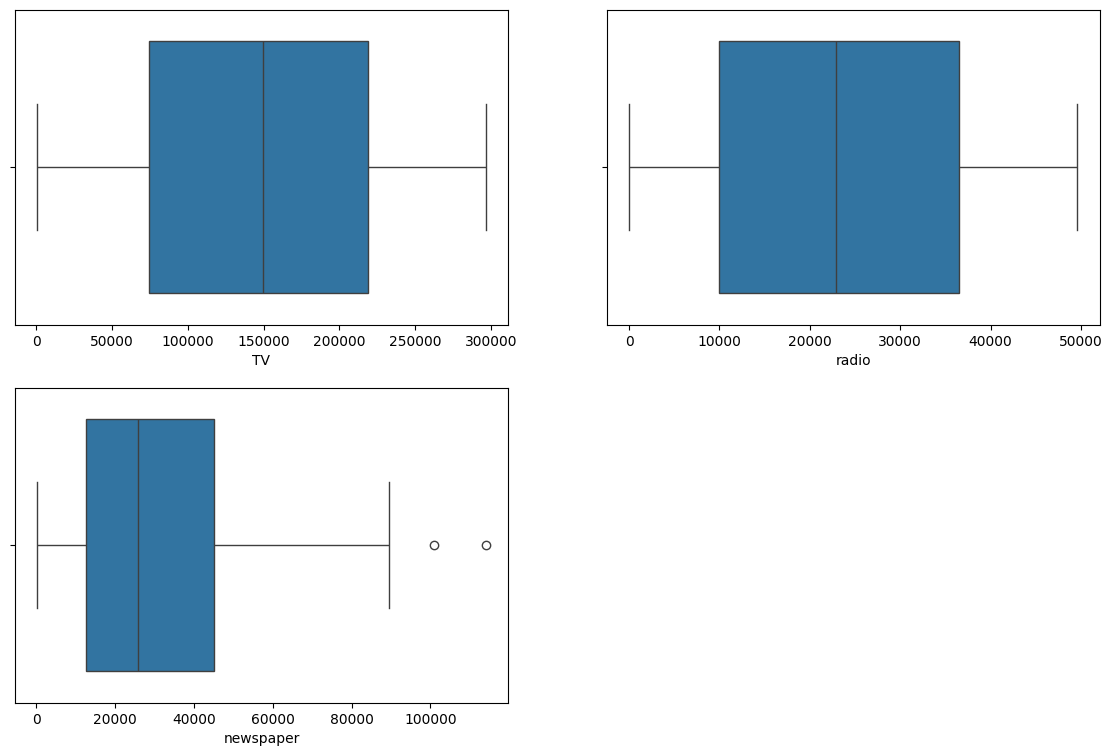

In [131]:
plt.figure(figsize=(14,9))

plt.subplot(2,2,1)
sns.boxplot(x=adv_df['TV'],orient='h')

plt.subplot(2,2,2)
sns.boxplot(x=adv_df['radio'],orient='h')

plt.subplot(2,2,3)
sns.boxplot(x=adv_df['newspaper'],orient='h')

plt.show()

**Insights**
- As we can see from above, newspaper has 2 outliers.
- We can either replace it with median values or cap them

In [132]:
Q1 = np.percentile(adv_df['newspaper'],25)
Q3 = np.percentile(adv_df['newspaper'],75)

IQR = Q3 - Q1

UB = Q3 + 1.5*IQR
LB = Q1 - 1.5*IQR

print(f"Quartile 3 for newspaper: {Q3}")
print(f"Quartile 1 for newspaper: {Q1}")
adv_df[(adv_df['newspaper'] > UB) | (adv_df['newspaper'] < LB)]['newspaper']

Quartile 3 for newspaper: 45100.0
Quartile 1 for newspaper: 12750.0


16     114000
101    100900
Name: newspaper, dtype: int64

- As we can see 2 outliers for newspaper are greater than Q3
- Lets cap them to UB

In [133]:
adv_df.loc[(adv_df['newspaper'] > UB),'newspaper'] = UB

- Now, check whether outliers for newspaper removed or not ?

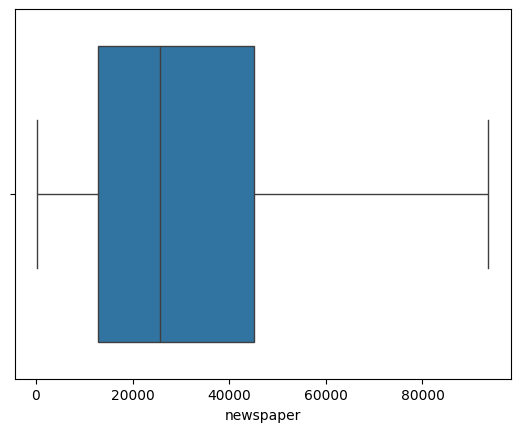

In [134]:
sns.boxplot(adv_df['newspaper'],orient='h')
plt.show()

**Lets check skew values & draw Histogram to check whether data is uniformly distributed or not**

In [135]:
adv_df['TV'].skew()

# This is close to Zero, so approximately normally distributed

-0.06985336213274594

In [136]:
adv_df['radio'].skew()

# This is also close to Zero, so approximately normally distributed

0.09417463149664534

In [137]:
adv_df['newspaper'].skew()

0.7498296547248895

**Insights**
- Based on skewness value, both 'radio' & 'TV' columns are approximately normally distributed
- But, 'newspaper' column is moderately right skewed
- We can crosscheck this by drawing histogram of 'newspaper'

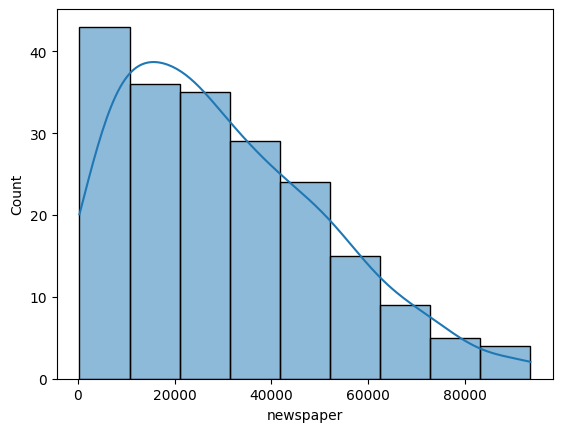

In [138]:
sns.histplot(x=adv_df['newspaper'],kde=True)
#sns.distplot(adv_df['newspaper'],bins=10)
plt.show()

- Lets try some Transformation techniques to make 'newspaper' uniform

Skewness value after log transformation: -1.1957631815970577


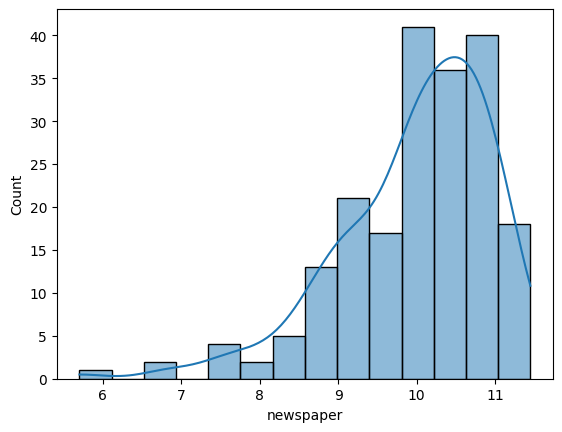

In [139]:
print(f"Skewness value after log transformation: {np.log(adv_df['newspaper']).skew()}")
sns.histplot(np.log(adv_df['newspaper']),kde=True)
plt.show()

Skewness value after Power transformation: -0.10389097059388638


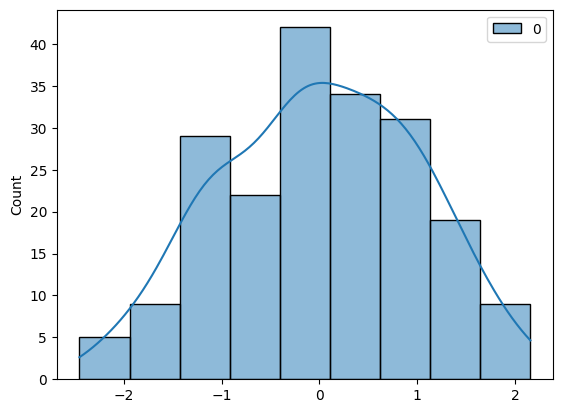

In [140]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
sns.histplot(pt.fit_transform(adv_df[['newspaper']]),kde=True)
print(f"Skewness value after Power transformation: {pd.Series(pt.fit_transform(adv_df[['newspaper']]).ravel()).skew()}")
plt.show()

Skewness value after sqrt transformation: 0.012135109582203544


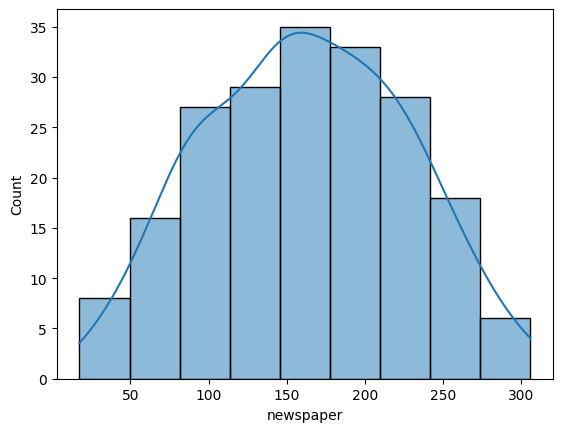

In [141]:
print(f"Skewness value after sqrt transformation: {np.sqrt(adv_df['newspaper']).skew()}")
sns.histplot(np.sqrt(adv_df['newspaper']),kde=True)
plt.show()

- As, we can see from above, among log, power & sqrt transformations, sqrt gives skewness value close to zero.
- So, lets stick with sqrt

In [142]:
adv_df['newspaper'] = np.sqrt(adv_df['newspaper'])

**Feature Scaling to make all columns on same scale**

In [143]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [144]:
for col in continous_col:
    adv_df[col] = ss.fit_transform(adv_df[[col]])

In [146]:
dump(ss,open('scalar.pkl','wb'))

In [147]:
adv_df

,TV,radio,newspaper,sales
0,0.97,0.98,1.58,22100
1,-1.20,1.08,0.78,10400
2,-1.52,1.53,1.58,9300
3,0.05,1.22,1.25,18500
4,0.39,-0.84,1.24,12900
...,...,...,...,...
195,-1.27,-1.32,-0.70,7600
196,-0.62,-1.24,-1.13,9700
197,0.35,-0.94,-1.29,12800
198,1.59,1.27,1.49,25500


In [148]:
X = adv_df[continous_col]
y = adv_df['sales']

**Choosing the best random state**

In [149]:
Train = []
CV = []
for i in range(0,100):
    
    from sklearn.model_selection import train_test_split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    from sklearn.linear_model import LinearRegression 
    model = LinearRegression() 
    model.fit(X_train,y_train)
    
    ypred_train = model.predict(X_train)
    
    from sklearn.metrics import r2_score 
    Train.append(r2_score(y_train, ypred_train))
    
    from sklearn.model_selection import cross_val_score 
    CV.append(cross_val_score(model, X_train, y_train, cv=5).mean())

em = pd.DataFrame({"Train_Score": Train, "CV_Score":CV})
gm = em[(abs(em['Train_Score']-em['CV_Score'])<0.05)]
rs = gm[gm["CV_Score"]==gm["CV_Score"].max()].index.to_list()[0]
print("best random state number:",rs)

best random state number: 10


### **Step-5 Modelling**

In [150]:
X = adv_df[continous_col]
y = adv_df['sales']

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")

Coefficients: [3747.564524 2862.372812 -46.951080]
Intercept: 14122.10760973624


### **Step-6 Evaluation**

In [152]:
## Prediction on Train data
ypred_train = lr.predict(X_train)

## Evaluation on Train Data
from sklearn.metrics import r2_score
print(f"Train R_Sq = {r2_score(y_train,ypred_train)}")

Train R_Sq = 0.9209085830997107


In [153]:
## Cross Validation on Train Data
from sklearn.model_selection import cross_val_score
print(f"Cross Validation Score: {cross_val_score(lr,X_train,y_train,cv = 5).mean()}")

Cross Validation Score: 0.9158232692056482


In [154]:
## Prediction & Evaluation on Test Data
ypred_test = lr.predict(X_test)

print(f"Test R_sq = {r2_score(y_test,ypred_test)}")

Test R_sq = 0.8349652208779064


### **Step-7 Model Selection**

- condition 1. == Train accuracy =~ CV Score (Satisfied)
- condition 2. == Train accuracy =~ Test accuracy (Not Satisfied)  So, Test Error > Train Error i.e model is **Overfitting Problem**
- condition 3. == Business Problem Understanding (Not Satisfied)
- condition 4. == Below Assumptions must be satisfied (ONLY FOR MULTIPLE LINEAR REGRESSION)

**Multiple Linear Regression (MLR) has several key assumptions that must be satisfied for the model to produce valid and reliable results. Violating these assumptions can lead to biased or inefficient estimates of the regression coefficients. Here are the main assumptions:**

- 1. $Linearity$:
The relationship between the independent variables (predictors) and the dependent variable (target) should be linear. In other words, the change in the dependent variable is assumed to be proportional to the change in each independent variable.

    - How to check:

        - Plot the residuals against the predicted values. If there is no clear pattern (e.g., random scatter), linearity is likely satisfied.
        - Use scatterplots to visualize relationships between individual predictors and the dependent variable.
- 2. $Independence of Errors (No Autocorrelation)$:
The residuals (errors) should be independent of each other. This is particularly important in time series data, where errors might be correlated across time (autocorrelation).

    - How to check:

        - Durbin-Watson test can be used to detect autocorrelation.
        - Plot residuals over time to check for patterns. If there is no systematic pattern, the assumption is likely satisfied.
- 3. $Homoscedasticity (Constant Variance of Errors)$:
The variance of the residuals should be constant across all levels of the independent variables. This means that the spread of residuals should not change as the predicted values change.

    - How to check:

        - Plot residuals against predicted values. If the spread of residuals is constant (i.e., no funnel shape), homoscedasticity is likely satisfied.
        - Breusch-Pagan test or White test can formally check for heteroscedasticity (non-constant variance).
- 4. $No Multicollinearity$:
The independent variables should not be highly correlated with each other. Multicollinearity occurs when two or more predictors are strongly correlated, making it difficult to isolate the individual effects of each variable on the dependent variable.

    - How to check:

        - Variance Inflation Factor (VIF): A VIF value greater than 5 or 10 suggests problematic multicollinearity.
        - Correlation matrix: Look for high correlations between the independent variables (greater than 0.7–0.8).
- 5. $Normality of Errors$:
The residuals (errors) should follow a normal distribution. This is important for valid hypothesis testing and constructing confidence intervals.

    - How to check:

        - Plot a histogram or Q-Q plot of the residuals. If the distribution is approximately normal, the assumption is satisfied.
        - Use formal tests like the Shapiro-Wilk test or Anderson-Darling test to check for normality.

**1. Linearity of Errors**

- As we saw already above in data preprocessing, there is linear relationship b/w each predictor & target variable except 'newspaper' column
- Now, here we will see plot b/w residuals vs Predicted values

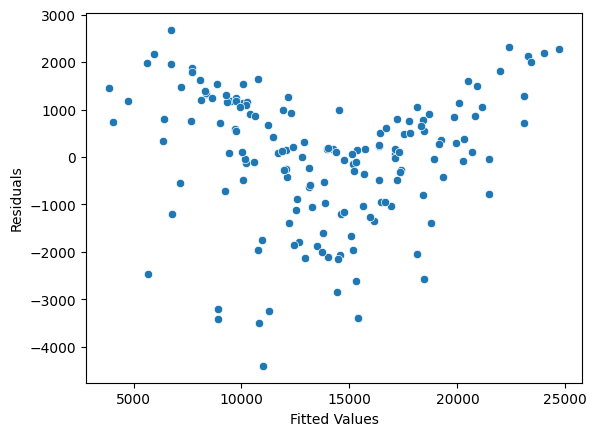

In [155]:
residuals = y_train - ypred_train

sns.scatterplot(x=ypred_train,y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

**Insights**
- As we can see, there is no clear pattern in above graph, so Linearity is satisfied

**2. Homoscedasticity (Constant variance of errors)**
- Plot residuals vs predicted values from Training data

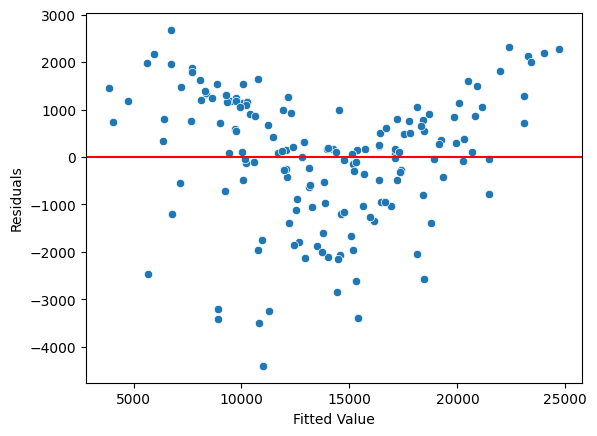

In [156]:
sns.scatterplot(x=ypred_train,y=residuals)
plt.axhline(y=0,color='red')
plt.xlabel('Fitted Value')
plt.ylabel('Residuals')
plt.show()

**Insights**
- Clearly, there is no constant variance of error above becasue
- Scatter points below 0 lies till -4000 while above 0, it lies till 3000
- So, Homoscedasticity is NOT satisfied

**3. Normaltiy of Errors**
- We will plot histogram of residuals

-0.7041686173778944


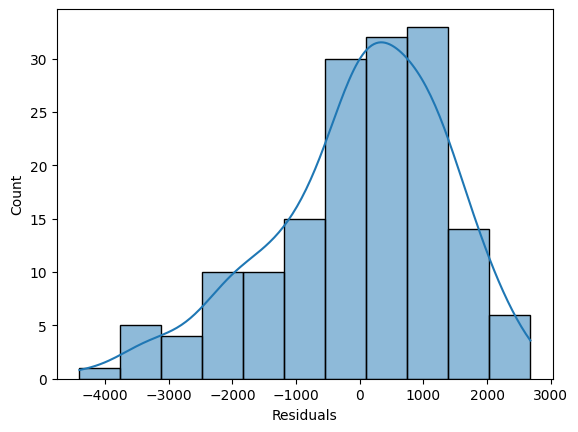

In [157]:
print(residuals.skew())
sns.histplot(x=residuals,kde=True)
plt.xlabel('Residuals')
plt.show()

**Insights**
- From above, we can say that it is slighly left skewed.
- So, Normality is also NOT satisfied

**4. No Multicollinearity**
- We already checked VIF values above (in Data Preprocessing) for predictor variables
- 2nd Option is after modelling also, we can check multicollinearity

In [158]:
from statsmodels.formula.api import ols
Rsq_TV = ols('TV ~ radio + newspaper', data = adv_df).fit().rsquared
VIF_TV = 1/(1-Rsq_TV)

Rsq_radio = ols('radio ~ TV + newspaper',data = adv_df).fit().rsquared
VIF_radio = 1/(1-Rsq_radio)

Rsq_np = ols('newspaper ~ radio + TV',data = adv_df).fit().rsquared
VIF_np = 1/(1-Rsq_np)

VIF = pd.DataFrame()
VIF['Features'] = ['TV','radio','newspaper']
VIF['vif_values'] = [VIF_TV,VIF_radio,VIF_np]

VIF

,Features,vif_values
0,TV,1.00
1,radio,1.11
2,newspaper,1.11


**Insights**
- Clearly, there is no multicollinearty b/w input variables

In [159]:
# import statsmodels.formula.api as smf
# Rsq_TV = smf.ols('TV ~ radio + newspaper', data = org_df).fit().rsquared
# VIF_TV = 1/(1-Rsq_TV)

# Rsq_radio = smf.ols('radio ~ TV + newspaper',data = org_df).fit().rsquared
# VIF_radio = 1/(1-Rsq_radio)

# Rsq_np = smf.ols('newspaper ~ radio + TV',data = org_df).fit().rsquared
# VIF_np = 1/(1-Rsq_np)

# VIF = pd.DataFrame()
# VIF['Features'] = ['TV','radio','newspaper']
# VIF['vif_values'] = [VIF_TV,VIF_radio,VIF_np]

# VIF

#### **Variables Significance**

**Hypothesis Testing to check significance of variables**

- Null Hypothesis: There is no relation b/w input variable & target variable & thus (coefficient $beta1$ = 0)
- Alternate Hypothesis: There is relation b/w input variable & target variable & thus (coefficient $beta1$ != 0)

In [160]:
from statsmodels.formula.api import ols
model_ols = ols('sales~TV+radio+newspaper',data=adv_df).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.2
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           1.59e-96
Time:                        00:16:36   Log-Likelihood:                -1767.7
No. Observations:                 200   AIC:                             3543.
Df Residuals:                     196   BIC:                             3557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.402e+04    119.189    117.649      0.000    1.38e+04    1.43e+04
TV          3917.9675    119.428     32.806      0.000    3682.439    4153.496
radio       2779.5164    125.606     22.129      0.000    2531.803    3027.230
newspaper     14.8112    125.557      0.118      0.906    -232.804     262.427
==============================================================================
Omnibus:                       59.751   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.978
Skew:                          -1.321   Prob(JB):                     1.21e-32
Kurtosis:                       6.265   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Insights**
- From above, we observe that p_value for predictor - 'newspaper' is > 0.05
- that means, we accept null hypothesis for this input variable/feature
- that means, there is no relation b/w target variable & input variable 'newspaper'

**Further, we can confirm the significance of variables by plotting AV plot (Added variable plot)**
- It does partial differentiation instead of full differentiation

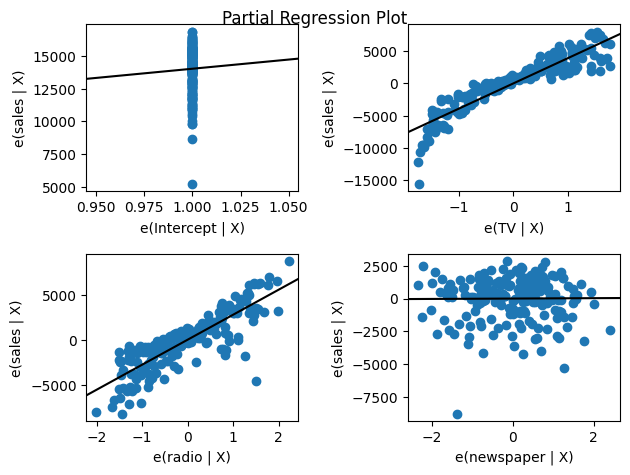

In [161]:
from statsmodels.api import graphics
graphics.plot_partregress_grid(model_ols)
plt.show()

- As we can see from above, AV plot for 'newspaper' not showing any significance. It is considering as average model for 'newspaper'

**Lets try removing influential records**

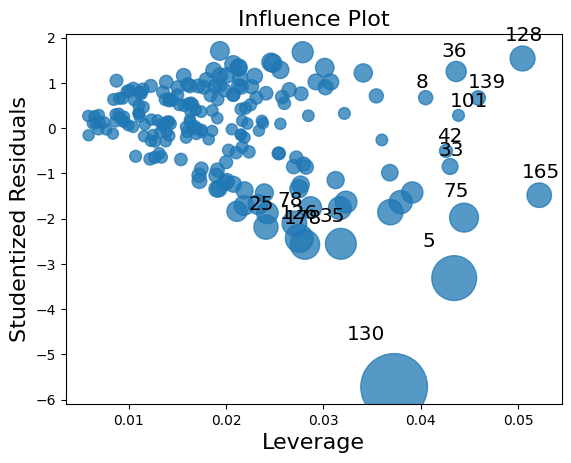

In [162]:
from statsmodels.api import graphics
graphics.influence_plot(model_ols)
plt.show()

**Dropping the influential records & then run the model**

In [163]:
adv_df.drop(index=[130,5,75,165,33,42,101,139,128,36,8,25,35,78],inplace=True)

In [164]:
X = adv_df[continous_col]
y = adv_df['sales']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

from sklearn.linear_model import LinearRegression
lr2 = LinearRegression()
lr2.fit(X_train,y_train)
print(f"Intercept: {lr2.intercept_}")
print(f"Coefficients: {lr2.coef_}")

ypred_train = lr2.predict(X_train)

from sklearn.metrics import r2_score
print(f"Train Rsq: {r2_score(y_train,ypred_train)}")


from sklearn.model_selection import cross_val_score
print(f"CV Score: {cross_val_score(lr2,X_train,y_train,cv=5).mean()}")


ypred_test = lr2.predict(X_test)
print(f"Test Rsq: {r2_score(y_test,ypred_test)}")


Intercept: 14227.781580525527
Coefficients: [3709.161673 2799.966651 205.030642]
Train Rsq: 0.924100956762597
CV Score: 0.9129515937769668
Test Rsq: 0.8932790740562917


**Insights**
- This time Test Rsq is in same range of Train Rsq

In [165]:
from statsmodels.formula.api import ols
ols('sales~TV+radio+newspaper',data=adv_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     690.0
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           3.95e-99
Time:                        00:17:14   Log-Likelihood:                -1612.7
No. Observations:                 186   AIC:                             3233.
Df Residuals:                     182   BIC:                             3246.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.416e+04    104.728    135.194      0.000     1.4e+04    1.44e+04
TV          3790.7543    109.942     34.480      0.000    3573.829    4007.680
radio       2798.4869    114.998     24.335      0.000    2571.586    3025.387
newspaper     64.3887    122.257      0.527      0.599    -176.836     305.613
==============================================================================
Omnibus:                       15.528   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.246
Skew:                          -0.741   Prob(JB):                     0.000180
Kurtosis:                       3.166   Cond. No.                         1.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Insights**
- From above, we still observe that p_value for predictor - 'newspaper' is > 0.05
- that means, we accept null hypothesis for this input variable/feature
- that means, there is no relation b/w target variable & input variable 'newspaper'

### **Final model including TV & Radio only & dropping influential records**

In [166]:
# Influential records, we already dropped above

X = adv_df[['TV','radio']]
y = adv_df['sales']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

from sklearn.linear_model import LinearRegression
lr3 = LinearRegression()
lr3.fit(X_train,y_train)

ypred_train = lr3.predict(X_train)

from sklearn.metrics import r2_score
print(f"Train R_sq = {r2_score(y_train,ypred_train)}")

from sklearn.model_selection import cross_val_score
print(f"CV Score = {cross_val_score(lr3,X_train,y_train,cv=5).mean()}")

ypred_test = lr3.predict(X_test)

print(f"Test R_sq = {r2_score(y_test,ypred_test)}")

Train R_sq = 0.9228821685287264
CV Score = 0.9140666175570994
Test R_sq = 0.9006350222331663


**Insights**
- After removing 'newspaper' variable & dropping influential records, we are getting Test R_sq, Train R_sq & Cv_score in the same range.


In [167]:
from statsmodels.formula.api import ols
ols('sales~TV+radio',data=adv_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1039.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          1.25e-100
Time:                        00:17:22   Log-Likelihood:                -1612.8
No. Observations:                 186   AIC:                             3232.
Df Residuals:                     183   BIC:                             3241.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.416e+04    104.375    135.680      0.000     1.4e+04    1.44e+04
TV          3794.6796    109.473     34.663      0.000    3578.689    4010.670
radio       2820.4823    106.934     26.376      0.000    2609.499    3031.465
==============================================================================
Omnibus:                       15.196   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.821
Skew:                          -0.732   Prob(JB):                     0.000223
Kurtosis:                       3.156   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Story Telling**
- After doing analysis & modelling, we found that 'newspaper' is not contributing in total sales generation.
- Focus on 'radio' & 'TV' only giving good results

In [168]:
# X = org_df[['TV','radio']]
# y = org_df['sales']

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

# from sklearn.linear_model import LinearRegression
# lr2 = LinearRegression()
# lr2.fit(X_train,y_train)

# ypred_train = lr2.predict(X_train)

# from sklearn.metrics import r2_score
# print(f"Train R_sq = {r2_score(y_train,ypred_train)}")

# from sklearn.model_selection import cross_val_score
# print(f"CV Score = {cross_val_score(lr2,X_train,y_train,cv=5).mean()}")

# ypred_test = lr2.predict(X_test)
# print(f"Test R_sq = {r2_score(y_test,ypred_test)}")

### **Model Deployment**

In [169]:
from pickle import dump

In [170]:
dump(lr3,open('lr3.pkl','wb'))

In [1]:
# from joblib import dump
# dump(lr3,'lr3.joblib')